In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import Sequential
from keras import layers
from keras import regularizers
from keras import initializers
from keras import optimizers
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
# remove extra commas at the beginning of some of the rows 
# which was causing an error when reading the data.
with open("testData.txt") as f:
    with open("testData_fixed.txt", "w") as f1:
        for line in f:
            if line[0] == ",":
                f1.write(line[1:])
            else:
                f1.write(line)
f1.close()
f.close()

# read data
data = pd.read_csv('testData_fixed.txt', sep=",")

In [3]:
# convert "dob" and "paymentDate" to datetime
from datetime import datetime
def process_dob(s):
    if len(s) == 8:
        d = datetime.strptime(s, '%Y%m%d')
    elif len(s) == 10:
        d = datetime.strptime(s, '%m/%d/%Y')
    else:
        return np.nan
    # I removed what appears to be the default value of dob when there is no data (1900)
    # as well as birthdate information that is obviously wrong (< 0 year old)
    if d.year == 1900 or d.year >= 2010:
        return np.nan
    return d

def process_paymentDate(s):
    if len(s) == 8:
        d = datetime.strptime(s, '%Y%m%d')
    elif len(s) == 10:
        d = datetime.strptime(s, '%m/%d/%Y')
    return d

# convert "dob" and "paymentDate" to datetime
data['dob'] = data['dob'].apply(process_dob)
data['paymentDate'] = data['paymentDate'].apply(process_paymentDate)

# replace missing values with 0 for values in "paymentAmount"
data['paymentAmount'] = data['paymentAmount'].apply(lambda x:0 if np.isnan(x) else x)

In [4]:
# a first glance of this data set
print(f"This data set contains {len(data)} rental payment records of {data['name'].nunique()} people \
from year {data['paymentDate'].min().year} to year {data['paymentDate'].max().year}.")

This data set contains 59813 rental payment records of 1989 people from year 2010 to year 2012.


### 1. What’s the relation between those fields?

#### a. Can one person live in more than one address? And vice versa?

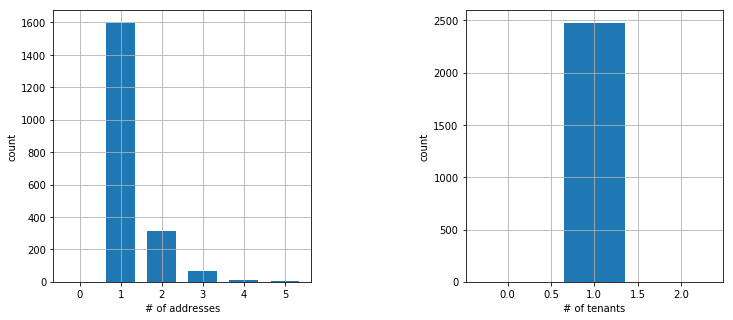

In [5]:
# number of houses a person has lived in during this data set
num_houses_per_person = data.groupby('name').nunique()['houseID']
# number of tenants in each house
num_tenants_per_house = data.groupby('houseID').nunique()['name']

fig = plt.figure(figsize=(12,5))
fig.subplots_adjust(wspace=0.6)

# histogram of the number of addresses
ax1 = plt.subplot(1, 2, 1)
ax1 = num_houses_per_person.hist(
    bins = np.arange(0, num_houses_per_person.max()+1.5)-0.5,rwidth=0.7)
ax1.set_xlabel('# of addresses')
ax1.set_ylabel('count')

# histogram of the number of tenants
ax2 = plt.subplot(1, 2, 2)
ax2 = num_tenants_per_house.hist(
    bins = np.arange(0, num_tenants_per_house.max()+2.5)-0.5,rwidth=0.7)
ax2.set_xlabel('# of tenants')
ax2.set_ylabel('count')
plt.show()

We can see most people live in the same address during the period of this data set. Some people lived in more than one addresses.

#### b. Can one address have different amount of rent? Payment?

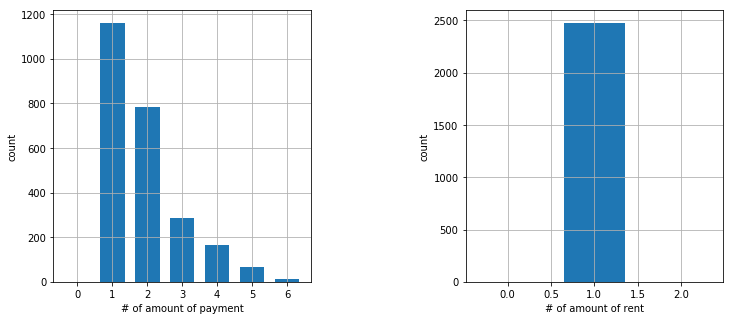

In [6]:
# Can one address have different amount of payment?
num_payment_per_house = data.groupby('houseID').nunique()['paymentAmount']
# Can one address have different amount of rent?
num_rent_per_house = data.groupby('houseID').nunique()['rentAmount']

fig = plt.figure(figsize=(12,5))
fig.subplots_adjust(wspace=0.6)

# histogram of the number of addresses
ax1 = plt.subplot(1, 2, 1)
ax1 = num_payment_per_house.hist(
    bins = np.arange(0, num_payment_per_house.max()+1.5)-0.5,rwidth=0.7)
ax1.set_xlabel('# of amount of payment')
ax1.set_ylabel('count')

# histogram of the number of addresses
ax2 = plt.subplot(1, 2, 2)
ax2 = num_rent_per_house.hist(
    bins = np.arange(0, num_rent_per_house.max()+2.5)-0.5,rwidth=0.7)
ax2.set_xlabel('# of amount of rent')
ax2.set_ylabel('count')
plt.show()

Each address has a fixed amount of rent. However, there can be up to 6 different amounts of payments (including missing payments).

### 2. We have a hypothesis that tenant’s age is related to the rent they pay.

#### a. Make a plot to check whether the hypothesis seems right?

Text(0, 0.5, 'amount of rent')

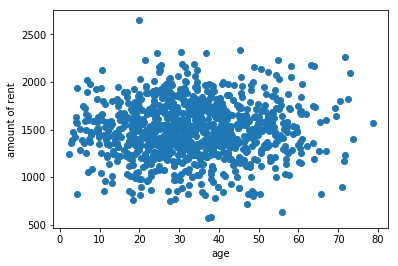

In [7]:
# add a new feature "age" which is more meaningful and easier to work with than "dob"
data['age'] = (data['paymentDate']-data['dob']).apply(lambda x:x.days/365.2425)

# plot rentAmount vs age
average_rent = data.groupby('name').mean()[['age','rentAmount']]
plt.scatter(average_rent['age'],average_rent['rentAmount'])
plt.xlabel('age')
plt.ylabel('amount of rent')

From the plot, there does not seem to be an obvious correlation between age and a tenant's monthly rent.

#### b. Can you do a statistical hypothesis testing on this?

In [8]:
# calcualte pearson coefficient
average_rent_nadropped = average_rent.dropna()
from scipy.stats.stats import pearsonr
r, p = pearsonr(average_rent_nadropped['age'],average_rent_nadropped['rentAmount'])
print(f"Pearson coefficient: {r}\np-value: {p}")

Pearson coefficient: 0.010946557548415165
p-value: 0.7330834859887433


I calculated the Pearson correlation coefficient and the p-value.

The Pearson correlation coefficient is very close to 0. The p-value is 0.73, meaning that we can't reject the null hypothesis that the correlation coefficient is in fact zero.

### 3. Is the payment amount always the same as the rent amount?


#### a. How many different situations are there if the payment is different?

Text(0, 0.5, 'count')

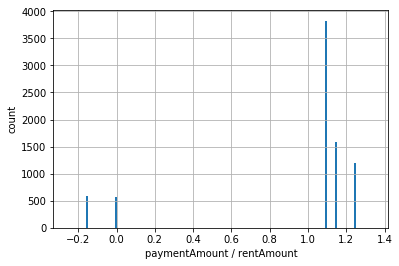

In [9]:
data['payment_ratio'] = data['paymentAmount'].divide(data['rentAmount'])
data['payment_ratio'][data['payment_ratio']!=1].hist(
    bins=np.arange(data['payment_ratio'].min()-0.1, data['payment_ratio'].max()+0.1, 0.01), 
    rwidth=10)
plt.xlabel('paymentAmount / rentAmount')
plt.ylabel('count') 

In this data set, there are 3 different situations: overpayment (paymentAmount > rentAmount), 
missing payment (paymentAmount == 0) and negative payment (paymentAmount < 0).

To be more specific, there are 3 types of overpayment (10%, 15% and 25% of the monthly rent) and 1 type of negative payment (15% of the rent).

#### b. What do you think is the reason for those over payment? Can you try to verify your guess?

My initial thought on those overpayment is that these are utility bills that exceed the amount that is already included in the monthly rent. If this hypothesis is true, the overpayments should correlate with the month in a year, because the utility bills are likely affected by the weather. So I looked at the frequency of overpayment of each month.

Text(0, 0.5, 'frequency of overpayment')

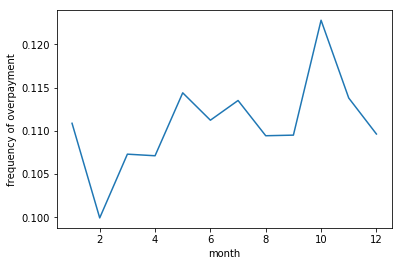

In [10]:
plt.plot(data[data['payment_ratio']>1].groupby(lambda x: 
    data[data['payment_ratio']>1]['paymentDate'].loc[x].month).count()['paymentDate'].divide(
    data.groupby(lambda x: data['paymentDate'].loc[x].month).count()['paymentDate']))
plt.xlabel('month')
plt.ylabel('frequency of overpayment') 

From the plot above, I didn't see a strong correlation between overpayment frequency and the month of year. 

So I looked at other parameters and eventually I found that overpayments are correlated with the day in the month.

Text(0, 0.5, 'payment count')

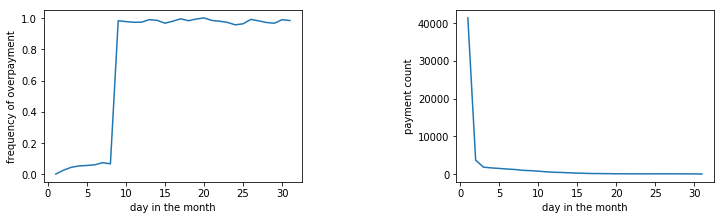

In [11]:
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.4, wspace=0.6)

ax1 = plt.subplot(3, 2, 1)
ax1 = plt.plot(data[data['payment_ratio']>1].groupby(
        lambda x: data['paymentDate'].loc[x].day).count()['paymentDate'].divide(
        data.groupby(lambda x: data['paymentDate'].loc[x].day).count()['paymentDate']))
plt.xlabel('day in the month')
plt.ylabel('frequency of overpayment') 

ax2 = plt.subplot(3, 2, 2)
ax2 = plt.plot(data.groupby(lambda x: data['paymentDate'].loc[x].day).count()['paymentDate'])
plt.xlabel('day in the month')
plt.ylabel('payment count')

From the plot on the right, it is clear that most payments were made on the first day of each month. From the plot on the left, we can see there is an overpayment for almost all payments made after day 8 in the month.

It is very likely that the overpayment is the late fee. The rent is due on the first day of each month and there is a 7-day grace period.

Text(0, 0.5, 'frequency of 25% overpayment')

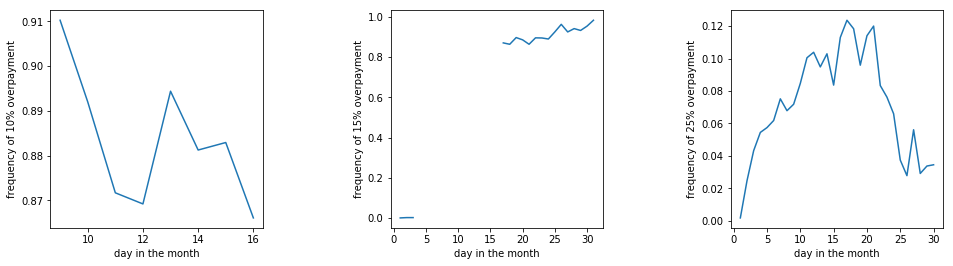

In [12]:
fig = plt.figure(figsize=(16,4))
fig.subplots_adjust(wspace=0.6)

ax1 = plt.subplot(1, 3, 1)
ax1 = plt.plot(data[data['payment_ratio'].between(1.09,1.11)].groupby(
        lambda x: data['paymentDate'].loc[x].day).count()['paymentDate'].divide(
        data.groupby(lambda x: data['paymentDate'].loc[x].day).count()['paymentDate']))
plt.xlabel('day in the month')
plt.ylabel('frequency of 10% overpayment') 

ax1 = plt.subplot(1, 3, 2)
ax1 = plt.plot(data[data['payment_ratio'].between(1.14,1.16)].groupby(
        lambda x: data['paymentDate'].loc[x].day).count()['paymentDate'].divide(
        data.groupby(lambda x: data['paymentDate'].loc[x].day).count()['paymentDate']))
plt.xlabel('day in the month')
plt.ylabel('frequency of 15% overpayment') 

ax1 = plt.subplot(1, 3, 3)
ax1 = plt.plot(data[data['payment_ratio'].between(1.24,1.26)].groupby(
        lambda x: data['paymentDate'].loc[x].day).count()['paymentDate'].divide(
        data.groupby(lambda x: data['paymentDate'].loc[x].day).count()['paymentDate']))
plt.xlabel('day in the month')
plt.ylabel('frequency of 25% overpayment') 

I looked at 3 types of overpayments (10%, 15% and 25%) and found that 10% late fee applies when the payment is late within a week (day 9 - day 15), 15% when paid within the month and 25% when it is paid after a month.

#### c. What do you think is the reason for the missing payment? Can you try to verify your guess?


Text(0, 0.5, 'payment count')

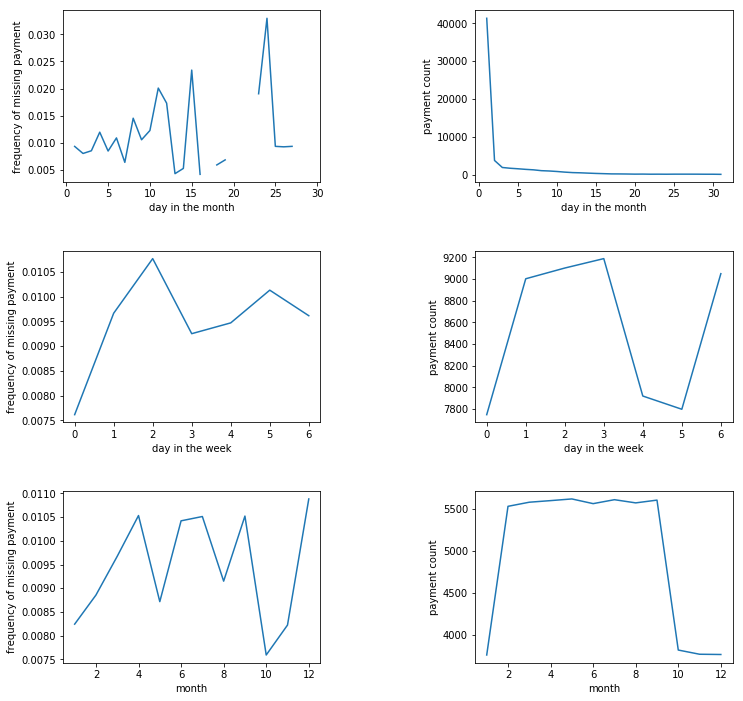

In [13]:
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.4, wspace=0.6)

ax1 = plt.subplot(3, 2, 1)
ax1 = plt.plot(data[data['payment_ratio']==0].groupby(
        lambda x: data['paymentDate'].loc[x].day).count()['paymentDate'].divide(
        data.groupby(lambda x: data['paymentDate'].loc[x].day).count()['paymentDate']))
plt.xlabel('day in the month')
plt.ylabel('frequency of missing payment') 

ax2 = plt.subplot(3, 2, 2)
ax2 = plt.plot(data.groupby(lambda x: data['paymentDate'].loc[x].day).count()['paymentDate'])
plt.xlabel('day in the month')
plt.ylabel('payment count')

ax3 = plt.subplot(3, 2, 3)
ax3 = plt.plot(data[data['payment_ratio']==0].groupby(
        lambda x: data['paymentDate'].loc[x].weekday()).count()['paymentDate'].divide(
        data.groupby(lambda x: data['paymentDate'].loc[x].weekday()).count()['paymentDate']))
plt.xlabel('day in the week')
plt.ylabel('frequency of missing payment')

ax4 = plt.subplot(3, 2, 4)
ax4 = plt.plot(data.groupby(lambda x: data['paymentDate'].loc[x].weekday()).count()['paymentDate'])
plt.xlabel('day in the week')
plt.ylabel('payment count')

ax5 = plt.subplot(3, 2, 5)
ax5 = plt.plot(data[data['payment_ratio']==0].groupby(
        lambda x: data['paymentDate'].loc[x].month).count()['paymentDate'].divide(
        data.groupby(lambda x: data['paymentDate'].loc[x].month).count()['paymentDate']))
plt.xlabel('month')
plt.ylabel('frequency of missing payment') 

ax6 = plt.subplot(3, 2, 6)
ax6 = plt.plot(data.groupby(lambda x: data['paymentDate'].loc[x].month).count()['paymentDate'])
plt.xlabel('month')
plt.ylabel('payment count')

Similar to overpayment data, I first checked if the missing payment behavior is correlated with date. However, I didn't see any obvious correlation.

Text(0, 0.5, 'frequency of missing payment')

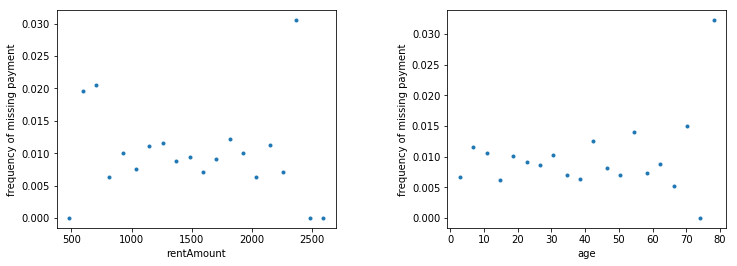

In [14]:
# check if missing payment is correlated with age or rent amount
data['missing_payment'] = data['payment_ratio'].apply(lambda x: 1 if x==0 else 0)

def calc_binned_freq(data, col1, col2, num_bins):
    width = (data[col1].max()-data[col1].min())/num_bins
    start = data[col1].min()
    freq = []
    mean = []
    for _ in range(num_bins):
        count_total = data[
            data[col1].between(start,start+width)].groupby(col1).count()[col2].sum()
        count_missing_payment = data[
            data[col1].between(start,start+width)].groupby(col1).sum()[col2].sum()
        freq.append(count_missing_payment/count_total if count_total else 0)
        mean.append(start + width/2)
        start += width
    return mean,freq

fig = plt.figure(figsize=(12,4))
fig.subplots_adjust(wspace=0.4)

ax1 = plt.subplot(1, 2, 1)
mean, freq = calc_binned_freq(data, 'rentAmount', 'missing_payment', 20)
ax1 = plt.plot(mean, freq,'.')
plt.xlabel('rentAmount')
plt.ylabel('frequency of missing payment') 

ax2 = plt.subplot(1, 2, 2)
mean, freq = calc_binned_freq(data, 'age', 'missing_payment', 20)
ax2 = plt.plot(mean, freq,'.')
plt.xlabel('age')
plt.ylabel('frequency of missing payment') 

I then checked whether this missing payment behavior is correlated with the rent amount or the age of the tenant, but there is still no correlation (the outliers are likely due to the small sample sizes in those rent amount or age groups).

Now I use chi square test to see whether some the categorical features are good indicators of this missing payment behavior.

In [15]:
from scipy.stats import chisquare
observed = data.groupby('houseZip').sum()['missing_payment']
expected = data.groupby('houseZip').count()['missing_payment']*(
    data['missing_payment'].sum()/data['missing_payment'].count())
chisquare(observed, expected)

Power_divergenceResult(statistic=69.70298155106119, pvalue=0.7877202581206623)

I performed chi square test on the zip codes and observed a p value of 0.79. 

Assuming there is no correlation between zip codes and missing payment behavior, the number of missing payments for each zip code should be proportional to the total number of payments in this area. A p-value of 0.79 shows that we cannot reject the null hypothesis that difference between our observation and the expected frequencies is not significant.

Zip code is probably not a good feature if used to predict missing payments.

In [16]:
from scipy.stats import chisquare
observed = data.groupby('name').sum()['missing_payment']
expected = data.groupby('name').count()['missing_payment']*(
    data['missing_payment'].sum()/data['missing_payment'].count())
chisquare(observed, expected)

Power_divergenceResult(statistic=1985.4849976037378, pvalue=0.5116986161300604)

I then performed chi square test on each tenant to check whether different tenants would have different missing payment behavior. Again, the result shows that there is no significant difference across tenants.

In [17]:
data['has_missed_before'] = 0
        
people_missing_payments = []
for idx in range(data.shape[0]):
    if data.at[idx,'name'] in people_missing_payments:
        data.at[idx,'has_missed_before'] = 1
    elif data.at[idx,'missing_payment']:
        people_missing_payments.append(data.at[idx,'name'])
        
print(f"""If a person has missed payments before, the frequency this person misses a payment is:
      {data[(data['has_missed_before']==1) & (data['missing_payment']==1)].count()['name']/data[
    data['has_missed_before']==1].count()['name']}""")

print(f"""If a person has not missed payments before, the frequency this person misses a payment is:
      {data[(data['has_missed_before']==0) & (data['missing_payment']==1)].count()['name']/data[
    data['has_missed_before']==0].count()['name']}""")

If a person has missed payments before, the frequency this person misses a payment is:
      0.009458408914226484
If a person has not missed payments before, the frequency this person misses a payment is:
      0.009540262981092236


I checked whether a person has missed payments before can be used to predict how likely a person will miss payments in the future. Again, this is not a very good indicator.

As far as I'm concerned, those missing payments also do not make much practical sense. If a tenant misses the payment for a month, this person should still make a payment sometime in the future before paying rent for the next month. However, it does not work this way in this data set. 

I suspect these missing payments are simply caused by human or computer errors. They are just payments that are not recorded properly. 

Another thing I did not figure out is the -15% payment in this data set. I'm not sure if these are considered "missing" payments but I could not find any clear correlation with other features and also I do not have any real life experience of this kind of payments. In reality, if a client sends me this data set, I will talk to the client and ask about it.

In [18]:
# remove the columns
data.drop(['has_missed_before','missing_payment'],axis=1,inplace=True)

### 4. What kinds of tenant behavior that the rental company will be interested in predicting? Can you build a machine learning model to predict that?

The rental company should be interested in predicting how likely a tenant will be late for payments. I will calculate this frequency for each person at each address.

Text(0, 0.5, 'count')

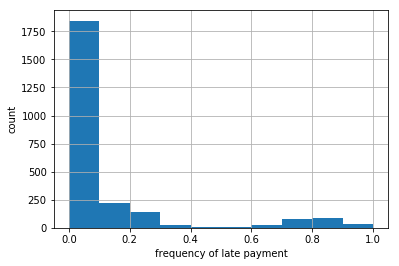

In [19]:
# calculate the frequency a person pays rent late at an address
late_frequency = data[
    data['payment_ratio']>1].groupby('houseID').count()['paymentDate'].divide(
    data.groupby('houseID').count()['paymentDate']).fillna(0)
# plot
late_frequency.hist()
plt.xlabel('frequency of late payment')
plt.ylabel('count') 

We can clearly see a bimodal distribution for the frequencies of late payment for different tenants. Among the tenants, about 10% are almost always late for their rent payments and the rest 90% are almost always on time. I will classify the tenants with higher than 50% late payment rate as unreliable tenants and these are the people the rental company should avoid.

In [20]:
data['unreliable'] = (late_frequency[data['houseID']].values>0.5)*1

#### a. How to design train/test split?

I will split the data in a way that all the payment record of each tenant only appears in a single set (either training or test set). So the model is not going to achieve high accuracy just by learning the identity of each person and use that to make predictions.

Also because only 10% of the tenants are labeled unreliable, I will over-sample those instances to compensate this imbalance.

#### b. How to deal with zipcode variable?
There are 81 unique zip codes. My first thought is to convert the zip codes to latitude and longitude coordinates on the map and use those as numerical features for learning. However, this is probably an artificial data set and I could not find the corresponding geographic coordinates for some of the zip codes. Also, some zip codes are actually PO boxes and do not correspond to residential areas. There is probably not much geographic information in the zip codes for this data set.

Before I treat zip codes as a categorical feature and use one-hot encoding, I checked whether it is a good feature at all.

Text(0, 0.5, 'count')

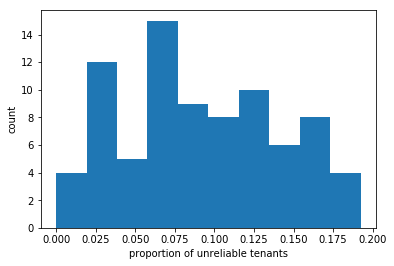

In [21]:
unreliable_by_zip = data.groupby(['houseZip','name']).mean().groupby(level=0).sum()['unreliable']
count_by_zip = data.groupby(['houseZip','name']).mean().groupby(level=0).count()['unreliable']

plt.hist(unreliable_by_zip.divide(count_by_zip))
plt.xlabel('proportion of unreliable tenants')
plt.ylabel('count') 

The histogram looks awfully like a normal distribution.

In [22]:
chisquare(unreliable_by_zip, count_by_zip*unreliable_by_zip.sum()/count_by_zip.sum())

Power_divergenceResult(statistic=65.09882880100496, pvalue=0.8862315529824911)

Chi square test also shows zip code is probably not a useful feature. So I will not include zip code as a feature.

#### c. How to deal with missing values (birthday)?

I use "age" instead of "birthday" for my model. For those people without DOB information, I will fill the values using the average age of all other tenants. In addition, I will add one more column "age_missing" to indicate whether a person's age is real or extrapolated.

In [23]:
# add feature "age missing"
data['age_missing'] = data['age'].isna()*1
# use average age to fill missing values
mean_age = data['age'].mean()
data['age'] = data['age'].apply(lambda x:mean_age if np.isnan(x) else x)

Now I will build a machine learning model to predict whether a new tenant will pay rent on time ("reliable"). For the training and validation data, I will create an instance for each tenant at each address and label whether this tenant is reliable at this address (assuming reliability is also a function of rent).

In [24]:
# group data by houseID so we have one instance for each tenant in each house
data_by_house = data.groupby('houseID').min().reset_index()
data_by_house['name'] = data_by_house['houseID'].apply(
    lambda x:data[data['houseID']==x]['name'].iloc[0])

# Select features for learning
data_processed = data_by_house[['name','rentAmount','age','age_missing','unreliable']].copy()

# split train and validation based on tenant names
tenants = data['name'].unique()
tenants_train, tenants_validation = train_test_split(tenants, test_size=0.3, shuffle=True)

# extract features and labels from data
def process_data(data, tenant_names):
    data_selected = data.loc[data['name'].isin(tenant_names)][[
        'rentAmount','age','age_missing','unreliable']]
    labels = data_selected['unreliable']
    features = data_selected.drop('unreliable',1)
    return features.values, labels.values

train_features, train_labels = process_data(data_processed, tenants_train)
validation_features, validation_labels = process_data(data_processed, tenants_validation)

# normalize features
def normalize(train_features, validation_features):
    train_features_n, validation_features_n = train_features, validation_features
    # normalize age and rentAmount
    mean = np.mean(train_features[:,:2], axis=0)
    std = np.std(train_features[:,:2], axis=0)
    train_features_n[:,:2] = (train_features[:,:2] - mean) / std
    validation_features_n[:,:2] = (validation_features[:,:2] - mean) / std
    return train_features_n, validation_features_n

train_features,validation_features = normalize(train_features, validation_features)

# over-sampling the minority class (tenants labeled unreliable)
from imblearn.over_sampling import SMOTE
train_features, train_labels = SMOTE().fit_sample(train_features, train_labels)

In [25]:
# train a neural network
model = Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(3,),
                      kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(8, activation='relu',
                      kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(0.0001),loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')

history = model.fit(train_features, train_labels,
                    epochs = 1000,
                    verbose= 0,
                    batch_size= 100,
                    validation_data=(validation_features, validation_labels),
                    callbacks=[es])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 00378: early stopping


#### d. How to evaluate your model performance?

The learning curve of the model can visualize how well the model learns. 

The model stops improving after about 300 epochs.

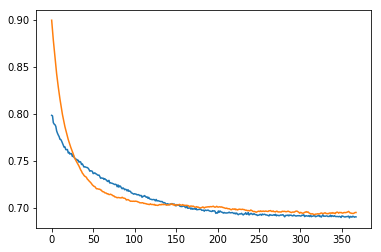

In [26]:
# evaluate result
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])

We can also measure the model performance using the recall on validation data. It shows how well the model can detect "unreliable" tenants.

In [27]:
# recall
print("The model recall is",
    metrics.recall_score(model.predict(validation_features).round(), validation_labels))    

The model recall is 0.06936416184971098


The recall is very close to the actual fraction of unreliable tenants. That means the prediction of the model is not better than chance.

I also trained a random forest model and again it does not perform well.

In [28]:
# random forest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=200, oob_score=True)
model_rf.fit(train_features,train_labels)

# recall
print("The model recall is",
    metrics.recall_score(model_rf.predict(validation_features).round(), validation_labels))    

The model recall is 0.07964601769911504


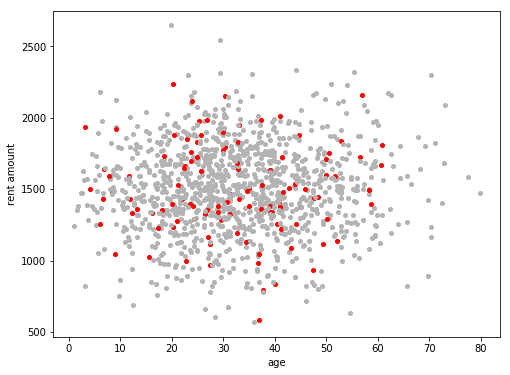

In [29]:
data_with_age = data_processed[data_processed['age_missing']==0]
colors = ['r' if x else '0.7' for x in data_with_age['unreliable']]
fig = plt.figure(figsize=(8,6))
plt.xlabel('age')
plt.ylabel('rent amount') 
for x, y, c in zip(data_with_age['age'], data_with_age['rentAmount'], colors):
    plt.plot(x, y, color=c, marker='o', markeredgecolor=c, markersize=4)    

In the rent amount vs age plot above, I labeled the unreliable tenants in red. Indeed, I do not think there is a pattern that can be learned.

Even though there are clearly two types of tenants, It seems like we cannot easily detect whether a new tenant will pay rent on time based on the information in this data set (age, rent amount and zip code). In order to create a prediction model that works, we probably need more information of the tenants (occupation, income, etc.).